In [2]:
Pe = 0.5/(2.5*10**-9)
Pe

200000000.0

# Flow
In this notebook we are going to analyse the effect of the incoming flow on the connectivity of the sedentary organisms

In [4]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import cmocean
from matplotlib.colors import ListedColormap, Normalize

In [22]:
foldername = '16objects'
flowset = ['parabolic','waveparabolic']
tstep = '001'
fb = 'forward'
d2cmax = 0.05
beaching_strategy = '2'
perarea = 1

filename = flowset[0]+'.nc'
flowdata = xr.open_dataset(foldername+'/'+filename)

dx = flowdata['X'][1]-flowdata['X'][0]
dy = dx


objects = np.load(foldername+'/preprocessed/'+'objects.npy')
x,y = np.meshgrid(flowdata['X'],flowdata['Y'])
xmesh,ymesh = np.meshgrid(np.arange(flowdata['X'].values[0]-0.5*dx, flowdata['X'].values[-1]+0.5*dx, dx),
                np.arange(flowdata['Y'].values[0]+0.5*dy, flowdata['Y'].values[-1]-1.5*dy, -dy))
xob,yob = np.meshgrid(np.arange(-0.5, len(objects)+0.5, 1),
                np.arange(-0.5, len(objects)+0.5, 1))
xfs,yfs = np.meshgrid(np.arange(-0.5, len(flowset)+0.5, 1),
                np.arange(-0.5, len(flowset)+0.5, 1))
my_cmap = ListedColormap(['dodgerblue','g','purple','darkorange','red','purple'])
labellist = [0, 1, 3, 4, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 19, 21]

If the connectivity matrices need to be calculated from new data, create the with the following cell. If you want to analyse existing adjacency matrices, skip the cell and proceed with the next.

In [23]:
conmatrix = np.zeros((len(flowset),len(objects),len(objects)))
noselfmatrix = np.zeros((len(flowset),len(objects),len(objects)))
for i,flow in enumerate(flowset):
    if perarea:
        conmatrix[i] = np.load(foldername+'/postprocessed/conmatrix-Single-Perarea-'+beaching_strategy+'-'+flow+'-'+tstep+'-'+str(d2cmax)+'.npy')
    else:
        conmatrix[i] = np.load(foldername+'/postprocessed/conmatrix-Single-'+beaching_strategy+'-'+flow+'-'+tstep+'-'+str(d2cmax)+'.npy')
    noselfmatrix[i] = conmatrix[i]
    np.fill_diagonal(noselfmatrix[i],0)

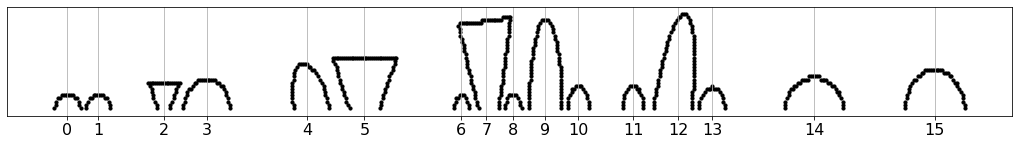

In [13]:
fig = plt.figure(figsize=(18,2))
ax = plt.axes()
ax.grid(axis='x')

plt.tick_params(      # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    top=False,         # ticks along the top edge are off
    left=False,      # ticks along the left edge are off
    labelleft=False) # labels along the left edge are off

xlocs = np.zeros(len(objects))
for i in range(len(objects)):
    xlocs[i] = np.mean(x[objects[i]])

plt.xticks(xlocs,np.arange(0,len(objects),1),fontsize=16)
for i in range(len(objects)):
    ax.scatter(x[objects[i]],y[objects[i]],s=10,c=['k'])
# plt.savefig('Figures/objectnumbers')

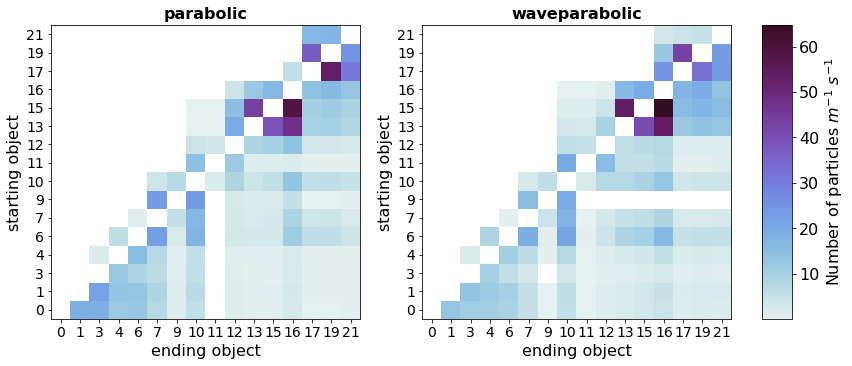

In [24]:
%matplotlib qt
colors =cmocean.cm.dense
cNorm = Normalize(vmin=0.1, vmax=np.max(noselfmatrix))
colors.set_under('w')

fig,ax = plt.subplots(1,2,figsize=(14,6))

for i in range(len(flowset)):
    pc = ax[i].pcolormesh(xob,yob,noselfmatrix[i],norm=cNorm,cmap = colors)
    ax[i].set_title(flowset[i],fontweight="bold",fontsize = 16)
    ax[i].set_xticks(np.arange(0,len(objects),1))
    ax[i].set_yticks(np.arange(0,len(objects),1))
    if foldername == '16objects':
        ax[i].set_xticklabels(labellist,fontsize = 14)
        ax[i].set_yticklabels(labellist,fontsize = 14)
    else:
        ax[i].set_xticklabels(np.arange(0,len(objects),1),fontsize = 12)
        ax[i].set_yticklabels(np.arange(0,len(objects),1),fontsize = 12)
    ax[i].set_xlabel("ending object",fontsize = 16)
    ax[i].set_ylabel("starting object",fontsize = 16)
#     ax[i].grid()
fig.subplots_adjust(bottom=0.2,right=0.8)
cbar_ax = fig.add_axes([0.83, 0.2, 0.03, 0.68])
if perarea:
    cbar = fig.colorbar(pc, cax=cbar_ax)
    cbar.set_label('Number of particles $m^{-1}$ $s^{-1}$',size=16)
    cbar.ax.tick_params(labelsize=16)
    plt.savefig('Figures/noselfmatrix-'+foldername+'-perarea-flowcomp')
else:
    cbar = fig.colorbar(pc, cax=cbar_ax)
    cbar.set_label('Number of particles $s^{-1}$',size=16)
    cbar.ax.tick_params(labelsize=16)
    plt.savefig('Figures/noselfmatrix-'+foldername+'-flowcomp')

In [7]:
DIFF = np.zeros((len(flowset),len(flowset),len(objects),len(objects)))
for i in range(len(DIFF)):
    for j in range(len(DIFF[i])):
        DIFF[i,j] = noselfmatrix[i] - noselfmatrix[j]

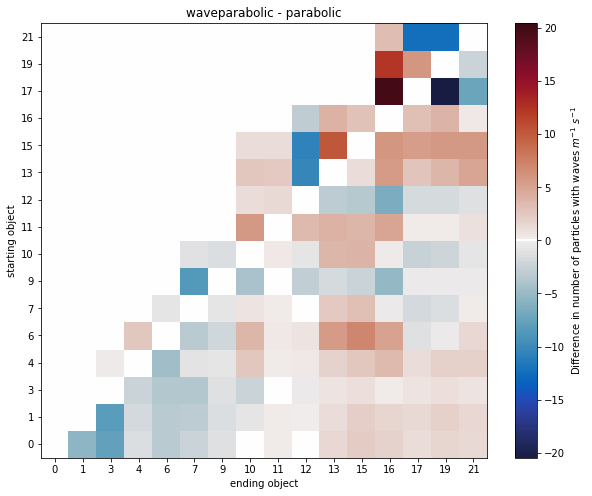

In [9]:
%matplotlib inline
colors = plt.get_cmap('cmo.balance')
cNorm = Normalize(vmin=-np.max([np.abs(np.min(DIFF)),np.max(DIFF)]), vmax=np.max([np.abs(np.min(DIFF)),np.max(DIFF)]))

newcolors = colors(np.linspace(0, 1, 500))
white = np.array([255/256, 255/256, 255/256, 1])
newcolors[250:252, :] = white
newcmp = ListedColormap(newcolors)

fig = plt.figure(figsize=(10,8))
ax = plt.axes()

pc = ax.pcolormesh(xob,yob,DIFF[1,0],norm=cNorm,cmap = newcmp)
ax.set_title(flowset[1]+' - '+flowset[0])
ax.set_xticks(np.arange(0,len(objects),1))
ax.set_yticks(np.arange(0,len(objects),1))
if len(objects)<20:
    ax.set_xticklabels(labellist)
    ax.set_yticklabels(labellist)
ax.set_xlabel("ending object")
ax.set_ylabel("starting object")
#     ax[i].grid()
# fig.subplots_adjust(bottom=0.3)
# cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.05])
if perarea:
    cbar = fig.colorbar(pc,label='Difference in number of particles with waves $m^{-1}$ $s^{-1}$')
    plt.savefig('Figures/'+foldername+'wavediff-perarea')
else:
    cbar = fig.colorbar(pc,label='Difference in number of particles with waves $s^{-1}$')
    plt.savefig('Figures/'+foldername+'wavediff')

IndexError: index 2 is out of bounds for axis 1 with size 2

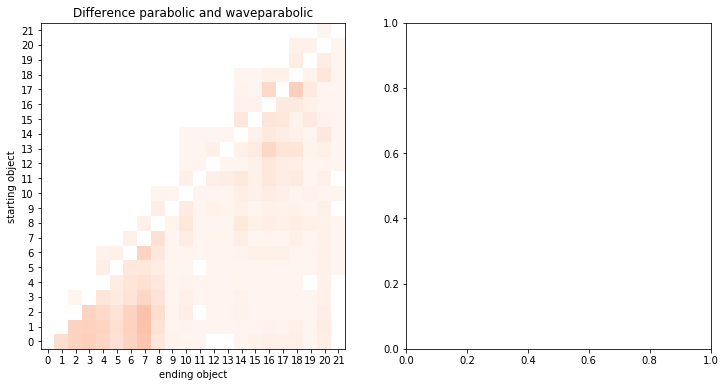

In [9]:
%matplotlib inline
colors = plt.get_cmap('Reds')
cNorm = Normalize(vmin=0.001, vmax=40)
colors.set_under('w')

fig,ax = plt.subplots(1,(len(flowset)),figsize=(6*(len(flowset)),6))

pc = ax[0].pcolormesh(xob,yob,DIFF[0,1],norm=cNorm,cmap = colors)
ax[0].set_title('Difference '+flowset[0]+' and '+flowset[1])
ax[0].set_xticks(np.arange(0,len(objects),1))
ax[0].set_yticks(np.arange(0,len(objects),1))
ax[0].set_xlabel("ending object")
ax[0].set_ylabel("starting object")

pc = ax[1].pcolormesh(xob,yob,DIFF[0,2],norm=cNorm,cmap = colors)
ax[1].set_title('Difference '+flowset[0]+' and '+flowset[2])
ax[1].set_xticks(np.arange(0,len(objects),1))
ax[1].set_yticks(np.arange(0,len(objects),1))
ax[1].set_xlabel("ending object")
ax[1].set_ylabel("starting object")

pc = ax[2].pcolormesh(xob,yob,DIFF[1,2],norm=cNorm,cmap = colors)
ax[2].set_title('Difference '+flowset[1]+' and '+flowset[2])
ax[2].set_xticks(np.arange(0,len(objects),1))
ax[2].set_yticks(np.arange(0,len(objects),1))
ax[2].set_xlabel("ending object")
ax[2].set_ylabel("starting object")


fig.subplots_adjust(bottom=0.3)
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.05])
cbar = fig.colorbar(pc,orientation='horizontal',label='Number of particles $m^{-1}$ $s^{-1}$', cax=cbar_ax)
plt.savefig('Figures/diffmatrix-perarea-flowcomp')

In [15]:
maxcolsum = np.zeros((len(DIFF),len(DIFF[0])))
maxrowsum = np.zeros((len(DIFF),len(DIFF[0])))
frobenius = np.zeros((len(DIFF),len(DIFF[0])))
for i in range(len(DIFF)):
    for j in range(len(DIFF[i])):
        maxcolsum[i,j] = np.amax(np.sum(np.absolute(DIFF[i,j]),axis=1))
        maxrowsum[i,j] = np.amax(np.sum(np.absolute(DIFF[i,j]),axis=0))
        frobenius[i,j] = np.sqrt(np.sum(np.square(np.absolute(DIFF[i,j]))))

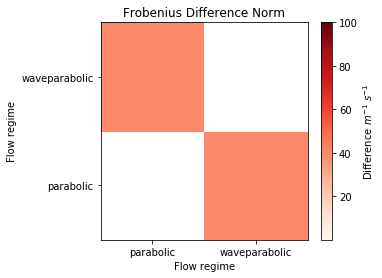

In [16]:
colors = plt.get_cmap('Reds')
cNorm = Normalize(vmin=0.001, vmax=100)
colors.set_under('w')

fig = plt.figure()
ax = plt.axes()

pc = ax.pcolormesh(xfs,yfs,frobenius,norm=cNorm,cmap = colors)
ax.set_title('Frobenius Difference Norm')
ax.set_xticks(np.arange(0,len(flowset),1))
ax.set_yticks(np.arange(0,len(flowset),1))
ax.set_xticklabels(flowset)
ax.set_yticklabels(flowset)
ax.set_xlabel("Flow regime")
ax.set_ylabel("Flow regime")

fig.subplots_adjust(left=0.3)
if perarea:
    cbar = fig.colorbar(pc,label='Difference $m^{-1}$ $s^{-1}$')
    plt.savefig('Figures/frobenius-perarea-flowcomp')
else:
    cbar = fig.colorbar(pc,label='Difference $s^{-1}$')
    plt.savefig('Figures/frobenius-flowcomp')

In [12]:
frobenius

array([[ 0.        , 40.13816821],
       [40.13816821,  0.        ]])

In [32]:
indegree = np.sum(noselfmatrix,axis=1)
outdegree = np.sum(noselfmatrix,axis=2)

In [33]:
%matplotlib qt
fig = plt.figure(figsize=(18,9))

heights = [3, 1]
spec = fig.add_gridspec(ncols=1, nrows=2, height_ratios=heights)

ax0 = fig.add_subplot(spec[0])
ax0.grid()

xlocs = np.zeros(len(objects))
for i in range(len(objects)):
    xlocs[i] = np.mean(x[objects[i]])
    
ax0.bar(xlocs,indegree[0],width=0.15,label=flowset[0],color=my_cmap(2))
ax0.bar(xlocs+0.05,indegree[1],width=0.15,label=flowset[1],color=my_cmap(3))
ax0.set_axisbelow(True)

ax0.set_xticks(xlocs)
if len(objects)>20:
    ax0.set_xticklabels(np.arange(0,len(objects),1))
else:
    ax0.set_xticklabels(labellist)
ax0.set_xlim(0.3,8.5)
ax0.set_xlabel("ending object",fontsize=18)
ax0.set_ylabel("In-degree [# of particles]",fontsize = 18)
ax0.legend(fontsize = 18)
ax0.tick_params(labelsize=16)

ax1 = fig.add_subplot(spec[1])
ax1.grid(axis='x')
ax1.set_xlim(0.3,8.5)

ax1.tick_params(      # changes apply to the x-axis
    labelsize = 16,
    which='both',      # both major and minor ticks are affected
    top=False,         # ticks along the top edge are off
    left=False,      # ticks along the left edge are off
    labelleft=False) # labels along the left edge are off

ax1.set_xticks(xlocs)
if len(objects)>20:
    ax1.set_xticklabels(np.arange(0,len(objects),1))
else:
    ax1.set_xticklabels(labellist)

for i in range(len(objects)):
    ax1.scatter(x[objects[i]],y[objects[i]],s=10,c=['k'])
    
plt.savefig('Figures/indegree'+foldername+'-flowcomp')

In [24]:
xlocs

array([0.8046875 , 1.0625    , 1.34461806, 1.609375  , 1.96875   ,
       2.4076087 , 2.80825893, 3.28766325, 3.77844929, 4.09765625,
       4.30654762, 4.52584135, 4.79973958, 5.07442434, 5.30682566,
       5.53495066, 5.91186523, 6.19449013, 6.63175061, 7.046875  ,
       7.53643932, 8.05354421])

Lower objects further down the flow direction like 15, 17 and 19 seem to be more connected in the uniform flow regime denoted by the cyan line. When checking this observation in the adjacency matrix, we can see that this connectivity is primarily caused by more intense connections with the direct neighbours 

Here we can look at the amount of fresh particles that interact with each object by looking at which object each particle interacts first with

In [41]:
conmatrix = np.zeros((len(flowset),len(objects)))
for i,flow in enumerate(flowset):
    conmatrix[i] = np.load(foldername+'/results/freshconmatrix-'+beaching_strategy+'-'+flow+'-'+tstep+'-'+str(d2cmax)+'.npy')

In [44]:
%matplotlib qt
fig = plt.figure(figsize=(18,9))

heights = [3, 1]
spec = fig.add_gridspec(ncols=1, nrows=2, height_ratios=heights)

ax0 = fig.add_subplot(spec[0])
ax0.grid()

xlocs = np.zeros(len(objects))
for i in range(len(objects)):
    xlocs[i] = np.mean(x[objects[i]])
    
for i in range(len(flowset)):
    ax0.plot(xlocs,conmatrix[i],label=flowset[i],c=my_cmap(i),linewidth=3)
ax0.set_xticks(xlocs)
ax0.set_xticklabels(np.arange(0,len(objects),1))
ax0.set_xlim(0.5,8.5)
ax0.set_xlabel("ending object",fontsize=18)
ax0.set_ylabel("# of 'fresh' particles",fontsize = 18)
ax0.legend(fontsize = 18)
ax0.tick_params(labelsize=16)

ax1 = fig.add_subplot(spec[1])
ax1.grid(axis='x')
ax1.set_xlim(0.5,8.5)

ax1.tick_params(      # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    top=False,         # ticks along the top edge are off
    left=False,      # ticks along the left edge are off
    bottom=False,
    labelbottom=False,
    labelleft=False) # labels along the left edge are off

ax1.set_xticks(xlocs)

for i in range(len(objects)):
    ax1.scatter(x[objects[i]],y[objects[i]],s=10,c=['k'])
plt.savefig('Figures/fresh-flowcomp')